<a href="https://colab.research.google.com/github/vikranthpulamathi/gw-odw25/blob/main/Tutorials/Day_1/Tuto_1.2_Open_Data_access_with_GWpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style="float: left;padding: 1.3em">![logo](https://github.com/gw-odw/odw/blob/main/Tutorials/logo.png?raw=1)</span>

# Gravitational Wave Open Data Workshop

## Tutorial 1.2: Introduction to GWpy

This tutorial will briefly describe GWpy, a python package for gravitational astrophysics, and walk-through how you can use this to speed up access to, and processing of, GWOSC data.

View this tutorial on [Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw/blob/main/Tutorials/Day_1/Tuto_1.2_Open_Data_access_with_GWpy.ipynb) or launch [mybinder](https://mybinder.org/v2/gh/gw-odw/odw/HEAD).


In [22]:
# Those 2 lines are just to avoid some harmless warnings when importing packages
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

## Installation (execute only if running on a cloud platform, like Google Colab, or if you haven't done the installation already!)

> ⚠️ **Warning**: restart the runtime after running the cell below.
>
> To do so, click "Runtime" in the menu and choose "Restart and run all".

In [23]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwpy==3.0.12'

## Initialization

In [24]:
# The first import of gwpy can take some time (especially on cloud platforms).
# This is mainly due to matplotlib taking some time to import (this is normal).
import gwpy
print(gwpy.__version__)

3.0.12


## A note on object-oriented programming

Before we dive too deeply, it's worth a quick aside on object-oriented programming (OOP).
[GWpy](https://gwpy.github.io/docs/stable/index.html) is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://medium.com/hackernoon/improve-your-python-python-classes-and-object-oriented-programming-d09ff461168d).

## Handling data in the time domain

#### Finding open data

We have seen already that the `gwosc` module can be used to query for what data are available on [GWOSC](https://gwosc.org/data/).
The next thing to do is to actually read some open data. Let's try to get some for GW190412, the first detection of a gravitational-wave signal from a significantly unequal-mass BBH (binary black hole system).

We can use the [TimeSeries.fetch_open_data](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://gwosc.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [25]:
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps)

1239082262.1


Now we can build a `[start, end)` GPS segment to 10 seconds around this time, using integers for convenience:

In [26]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1239082257, 1239082267)


and can now query for the full data.
For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`.
We could have chosen any of

- `'G1'` - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo
- `'K1'` - KAGRA


In [27]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(ldata)

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
            ...,  1.38850270e-19,  1.37760541e-19,
             1.38094202e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


##### The `verbose=True` flag lets us see that GWpy has discovered one file that provides the data for the given interval, downloaded it, and loaded the data.
The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer.

Notes:

* To control the dataset from which your data come from you can use the 'dataset' keyword. It is recommended to use data from a run if they are available, because they contain the most updated version of the calibration. To check which was the run at the time you want to query, it is enough to use the find_datasets method of the package gwosc discussed in the previous tutorial, specifying (`type='run',segment=segment`). For example, for the segment we are using in this tutorial, the two available datasets are [`'O3a_16KHZ_R1'`, `'O3a_4KHZ_R1'`]. For the sampling at 4 kHz, the complete command to get data from this dataset is then: `TimeSeries.fetch_open_data('L1', *segment, verbose=True, dataset='O3a_4KHZ_R1')`.  

* To read data from a local file instead of from the GWOSC server, we can use  [`TimeSeries.read`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.read) method.

We have now downloaded real LIGO data for GW190412! These are the actual data used in the analysis of this binary black hole merger.

To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/plot/) method of the `data` `TimeSeries`.

<div class="alert alert-info">
Since this is the first time we are plotting something in this notebook, we need to configure `matplotlib` (the plotting library) to work within the notebook properly:
</div>

Matplotlib documentation can be found [here](https://matplotlib.org/stable/users/index.html).

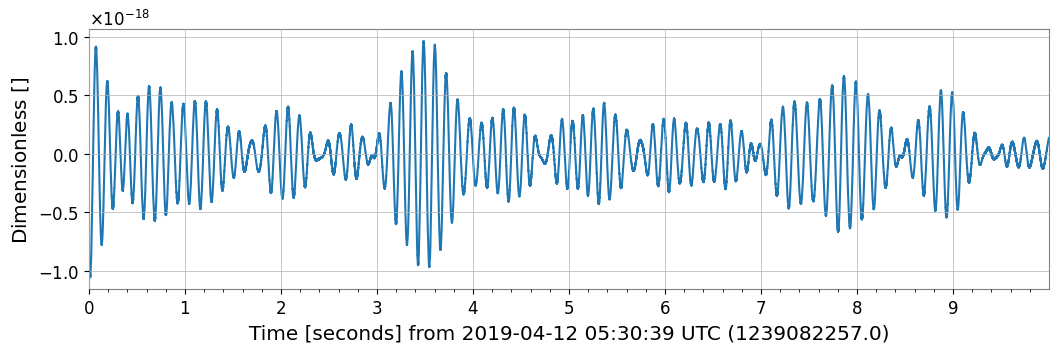

In [28]:
plot = ldata.plot()

Note: There are alternative ways to access GWOSC data. The [PyCBC](https:/pycbc.org) package has the `pycbc.frame.query_and_read_frame` and `pycbc.frame.read_frame` methods that we will learn in tutorials 2.1 to 2.3.

## Handling data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contain lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [fft()](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=fourier#gwpy.timeseries.TimeSeries.fft) method:

In [29]:
fft = ldata.fft()
print(fft)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905657e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871178e-26j,
                 -2.38345362e-23+1.80394058e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/api/gwpy.frequencyseries.FrequencySeries/#gwpy.frequencyseries.FrequencySeries), with complex amplitude, representing the amplitude and phase of each frequency in our data.
We can use `abs()` to extract the amplitude and plot it:

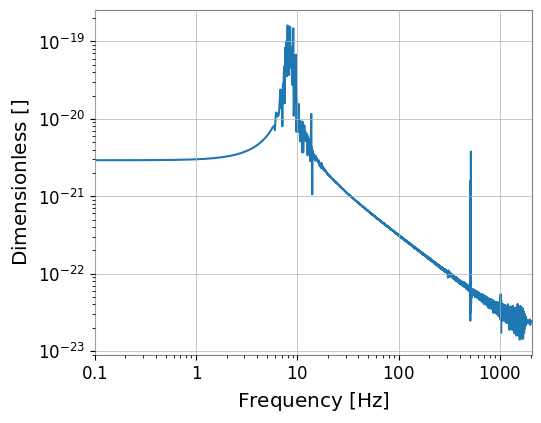

In [30]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

This doesn't look correct at all!
The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.
We need to apply a window function to our time-domain data before transforming, which we can do using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module:

In [31]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

Let's try our transform again and see what we get

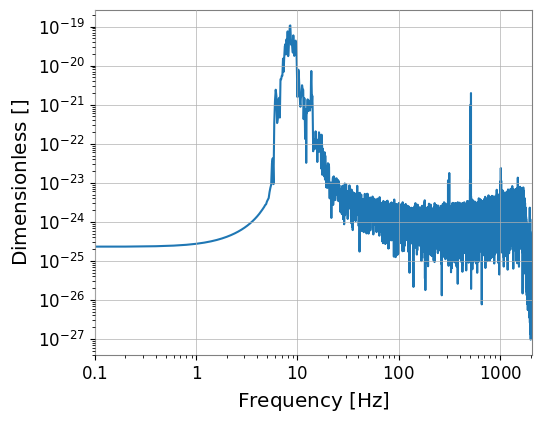

In [32]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Estimating the power spectral density

The dense fluctuations in the above plot at frequencies larger than 10 Hz seem completely random. This is indeed the intrinsic noise in the estimate of the spectral content of the signal from a single FFT. We can reduce these fluctuations by averaging many estimates of the signal FFT. But, being the FFT components complex quantities, what we really want to average are their squared moduli. This quantity is named [Power Spectral Density (PSD)](https://en.wikipedia.org/wiki/Spectral_density),  and what we have just described is [Welch's estimation method](https://en.wikipedia.org/wiki/Welch%27s_method).
It is also convenient to express the result not as a power but as an amplitude, taking the square root of the above expression. The resulting quantity takes the name Amplitude Spectral Density (ASD) of the signal.

GWpy library provides the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=asd#gwpy.timeseries.TimeSeries.asd) method of `TimeSeries`, which uses the above technique to combine FFTs estimated on overlapping, windowed chunks of data.

Alternatively, one could have combined the various FFT estimates calculating their median, which is a more robust statistic than the mean implemented in Welch's method with respect to spurious fluctuations of the signal level.

The `asd()` in GWpy accepts both `'median'` or `'welch'` as possible methods to estmate the ASD of a signal.

Explore the difference in the ASD estimate result by changing the values of the parameters `fftlength`, the duration in seconds of the data used to estimate each FFT, and the `method` used to average them. Take a look also at the [other optional parameters](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.asd-parameters).

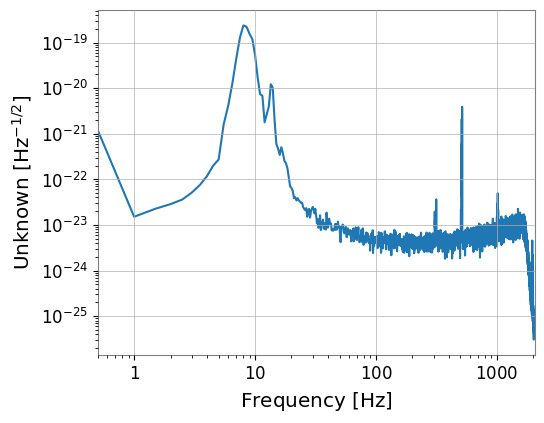

In [33]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
plot.show(warn=False)

Let's customize this figure by zooming in the frequency range of interest, that is, above the seismic noise shoulder at 10 Hz and below the cut-off at the Nyquist frequency, and resizing the y-axis accordingly.

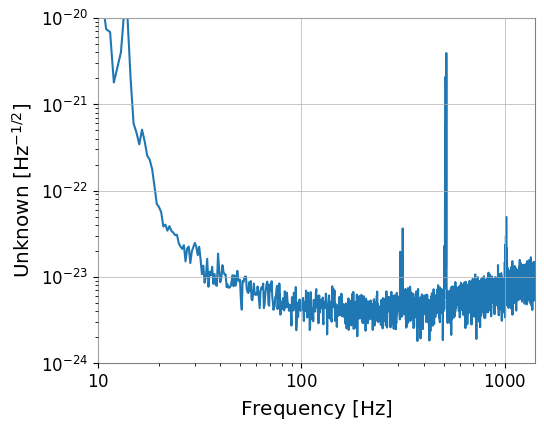

In [34]:
ax = plot.gca()
ax.set(xlim=(10, 1400), ylim=(1e-24, 1e-20))
plot

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Livingston data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O3 spectral lines](https://gwosc.org/O3/o3aspeclines/) page on GWOSC describes a number of these spectral features for O3, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD estimation, meaning random variations get averaged out, and we can see more detail:

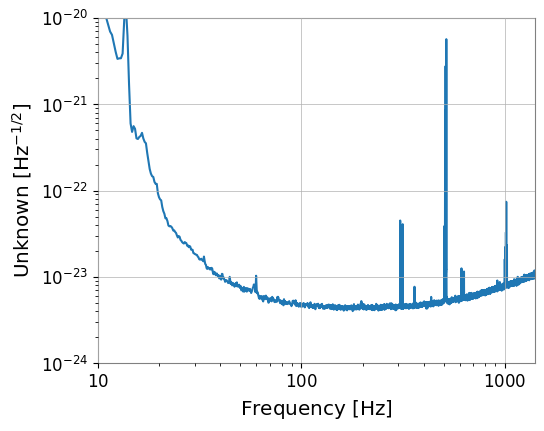

In [35]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

Now we can see some more features, including a small bump at about 60 Hz, the frequency of the electric mains in the US.

For comparison, we can load the LIGO-Hanford and Virgo data and plot them as well:

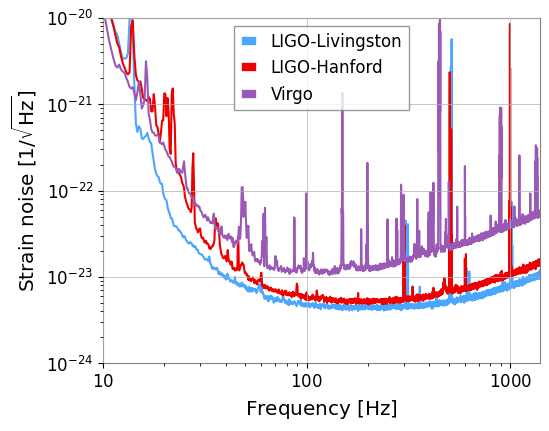

In [36]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each detectors of LIGO and Virgo, the common features between those, like the general trend at low and high frequency, and those unique to each observatory.

# Challenges:

## Quiz Question 1:

Looking at the LIGO-Livingston data in the time domain, the peak amplitude of the gravitational-wave signal of GW190412  occurs at the center of the figure, that is, at approximately 5 seconds from the start of the segment. This peak is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW190412. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? What about Virgo data?

<Figure size 1000x400 with 0 Axes>

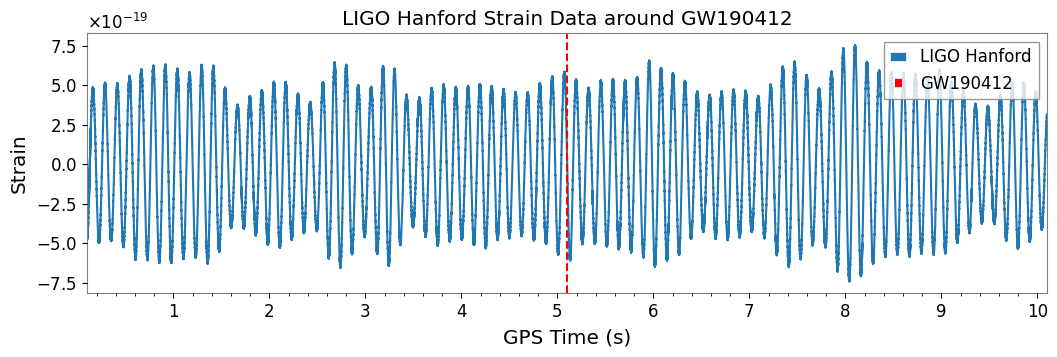

<Figure size 1000x400 with 0 Axes>

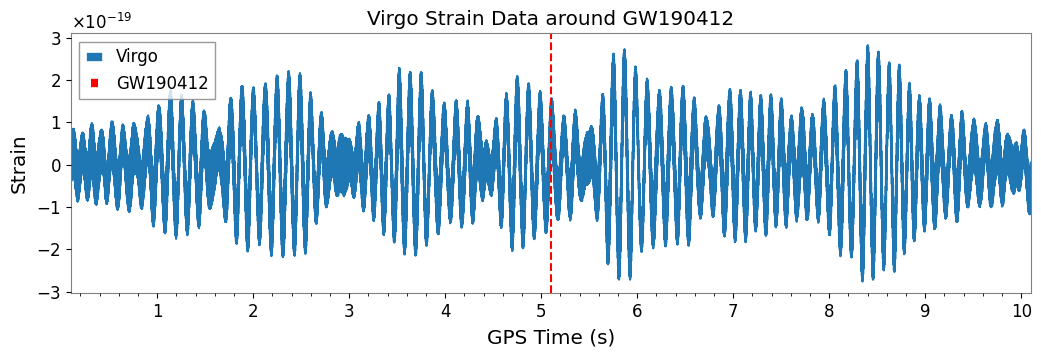

In [39]:
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import matplotlib.pyplot as plt

# Get GPS time for GW190412
gps = event_gps('GW190412')

# Set a duration around the event (e.g., ±5 seconds)
segment = (gps - 5, gps + 5)

# Load strain data from each detector
strain_H1 = TimeSeries.fetch_open_data('H1', segment[0], segment[1])
strain_V1 = TimeSeries.fetch_open_data('V1', segment[0], segment[1])

# Plotting H1 data
plt.figure(figsize=(10, 4))
strain_H1.plot(label='LIGO Hanford')
plt.axvline(gps, color='red', linestyle='--', label='GW190412')
plt.title('LIGO Hanford Strain Data around GW190412')
plt.xlabel('GPS Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.show()

# Plotting V1 data
plt.figure(figsize=(10, 4))
strain_V1.plot(label='Virgo')
plt.axvline(gps, color='red', linestyle='--', label='GW190412')
plt.title('Virgo Strain Data around GW190412')
plt.xlabel('GPS Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.show()


Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]


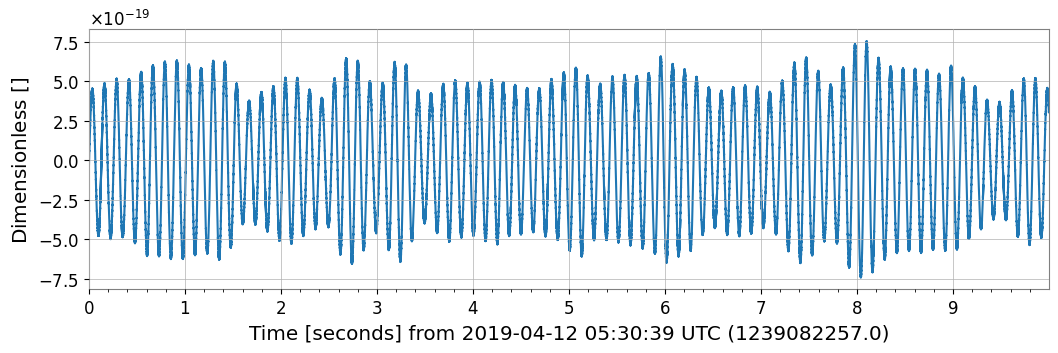

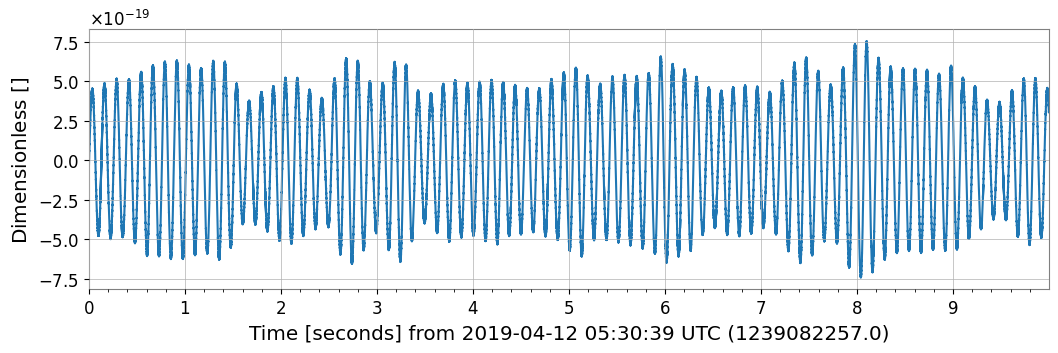

In [37]:
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps

gps = event_gps('GW190412')
segment = (int(gps)-5, int(gps)+5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
hdata.plot()

## Quiz Question 2 :

Make an ASD around the time of an O1 event, GW150914 for L1 detector.  Compare this with the ASDs around GW190412 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?


(10, 2000)

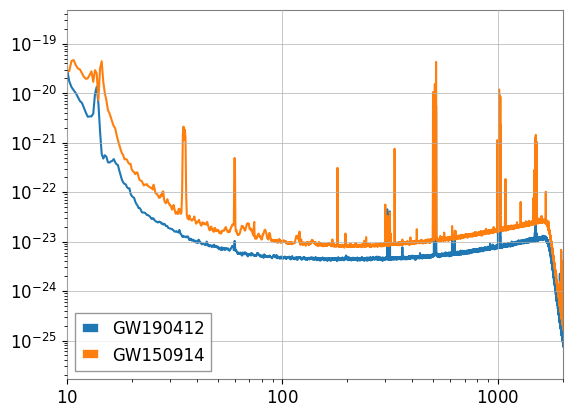

In [42]:
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import pylab as plt

gps = event_gps('GW190412')
ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd = ldata.asd(fftlength=4, method="median")

gps2 = event_gps('GW150914')
ldata2 = TimeSeries.fetch_open_data('L1', int(gps2)-512, int(gps2)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

plt.loglog(lasd, label = 'GW190412')
plt.loglog(lasd2,label = 'GW150914')
plt.legend()
plt.xlim(10,2000)